In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

In [56]:
import rpy2
%load_ext rpy2.ipython

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, validation_curve

# Preprocessing

In [3]:
data_raw = pd.read_csv("X.csv", index_col=0)
y_raw = pd.read_csv("y.csv")

In [4]:
y_raw.head()

,date,TICKER,Y
0,19860331,NOAX,1
1,19860331,ALD,1
2,19860331,AC,1
3,19860331,BU,0
4,19860331,BG,0


In [5]:
data_raw.head()

,date,CUSIP,PERMNO,SHRCD,TICKER,COMNAM,PRC,VOL,RET,CFACPR,...,makt_return42,makt_return63,makt_return126,makt_return252,makt_vol10,makt_vol21,makt_vol42,makt_vol63,makt_vol126,makt_vol252
0,20131031,00101J10,13567.0,11.0,ADT,A D T CORP,43.37,600485.0,0.069725,1.0,...,0.001662,0.000452,0.000695,0.000894,0.004258,0.007894,0.006774,0.006712,0.007143,0.007408
1,20131129,00101J10,13567.0,11.0,ADT,A D T CORP,40.56,707008.0,-0.064791,1.0,...,0.001532,0.001618,0.000788,0.000990,0.003751,0.005483,0.006762,0.006350,0.007066,0.007050
2,20131231,00101J10,13567.0,11.0,ADT,A D T CORP,40.47,590346.0,-0.002219,1.0,...,0.001138,0.001397,0.001095,0.001054,0.005181,0.005851,0.005670,0.006475,0.006122,0.006959
3,20140131,00101J10,13567.0,11.0,ADT,A D T CORP,30.04,1115969.0,-0.252780,1.0,...,-0.000284,0.000194,0.000366,0.000716,0.008682,0.007694,0.006979,0.006554,0.006625,0.007113
4,20140228,00101J10,13567.0,11.0,ADT,A D T CORP,30.71,1043797.0,0.022304,1.0,...,0.000263,0.000518,0.001045,0.000839,0.003916,0.007911,0.007822,0.007229,0.006834,0.007103


In [6]:
data_raw.shape

(343737, 84)

In [7]:
# drop na
data_raw = data_raw.dropna()
y_raw = y_raw.loc[data_raw.index]
data_raw.index = range(data_raw.shape[0])
y_raw.index = range(data_raw.shape[0])

In [8]:
if not isinstance(data_raw['date'][0], str):
    data_raw["date"] = data_raw["date"].apply(lambda x: str(x)[:4]+'-'+str(x)[4:6]+'-'+str(x)[6:])
data_raw["dateDT"] = pd.to_datetime(data_raw["date"])

if not isinstance(y_raw['date'][0], str):
    y_raw["date"] = y_raw["date"].apply(lambda x: str(x)[:4]+'-'+str(x)[4:6]+'-'+str(x)[6:])
y_raw["dateDT"] = pd.to_datetime(y_raw["date"])

In [9]:
data_raw = data_raw.sort_values(by=["dateDT", "TICKER"])
data_raw.index = range(data_raw.shape[0])

In [10]:
y_raw = y_raw.sort_values(by=["dateDT", "TICKER"])
y_raw.index = range(y_raw.shape[0])

In [11]:
data_raw["id"] = data_raw.index

In [12]:
# split train, val, test
train_val_split = int(data_raw.shape[0]*0.4)
val_test_split = int(data_raw.shape[0]*0.6)
X_train = data_raw.loc[data_raw["dateDT"] <= data_raw["dateDT"][train_val_split]]
train_cut = X_train.shape[0]
X_val = data_raw.iloc[train_cut:].loc[data_raw["dateDT"] <= data_raw["dateDT"][val_test_split]]
val_cut = train_cut + X_val.shape[0]
X_test = data_raw.iloc[val_cut:]

In [13]:
y_train = y_raw.iloc[:train_cut]
y_val = y_raw.iloc[train_cut:val_cut]
y_test = y_raw.iloc[val_cut:]

In [24]:
#feature_all = ['PRC', 'VOL']
feature_all = []

# add momentum terms
for i in range(1,22):
    feature_all.append("momentum" + str(i))
for i in range(42,253,21):
    feature_all.append("momentum" + str(i))

K = []
for i in [10,21]:
    K.append(i)
for i in range(42,253,21):
    K.append(i)
for k in K:
    feature_all.append('alpha' + str(k))
    feature_all.append('beta' + str(k))
feature_all.extend(['makt_return10',
 'makt_return21',
 'makt_return42',
 'makt_return63',
 'makt_return126',
 'makt_return252',
 'makt_vol10',
 'makt_vol21',
 'makt_vol42',
 'makt_vol63',
 'makt_vol126',
 'makt_vol252'])

In [29]:
X_train = X_train[feature_all]
X_val = X_val[feature_all]
X_test = X_test[feature_all]

#y_train = y_train['Y']
#y_val = y_val['Y']
#y_test = y_test['Y']

n1 = X_train.shape[0]
n2 = X_val.shape[0]
n3 = X_test.shape[0]

In [38]:
print(n1, n2, n3)

137743 68629 137365


Use the following

`X_train`, `y_train`

`X_val`, `y_val`

`X_test`, `y_test`

# Descriptive Analysis

### Base rate

In [31]:
(y_train == 1).mean()

0.49891464539032837

### Correlation map

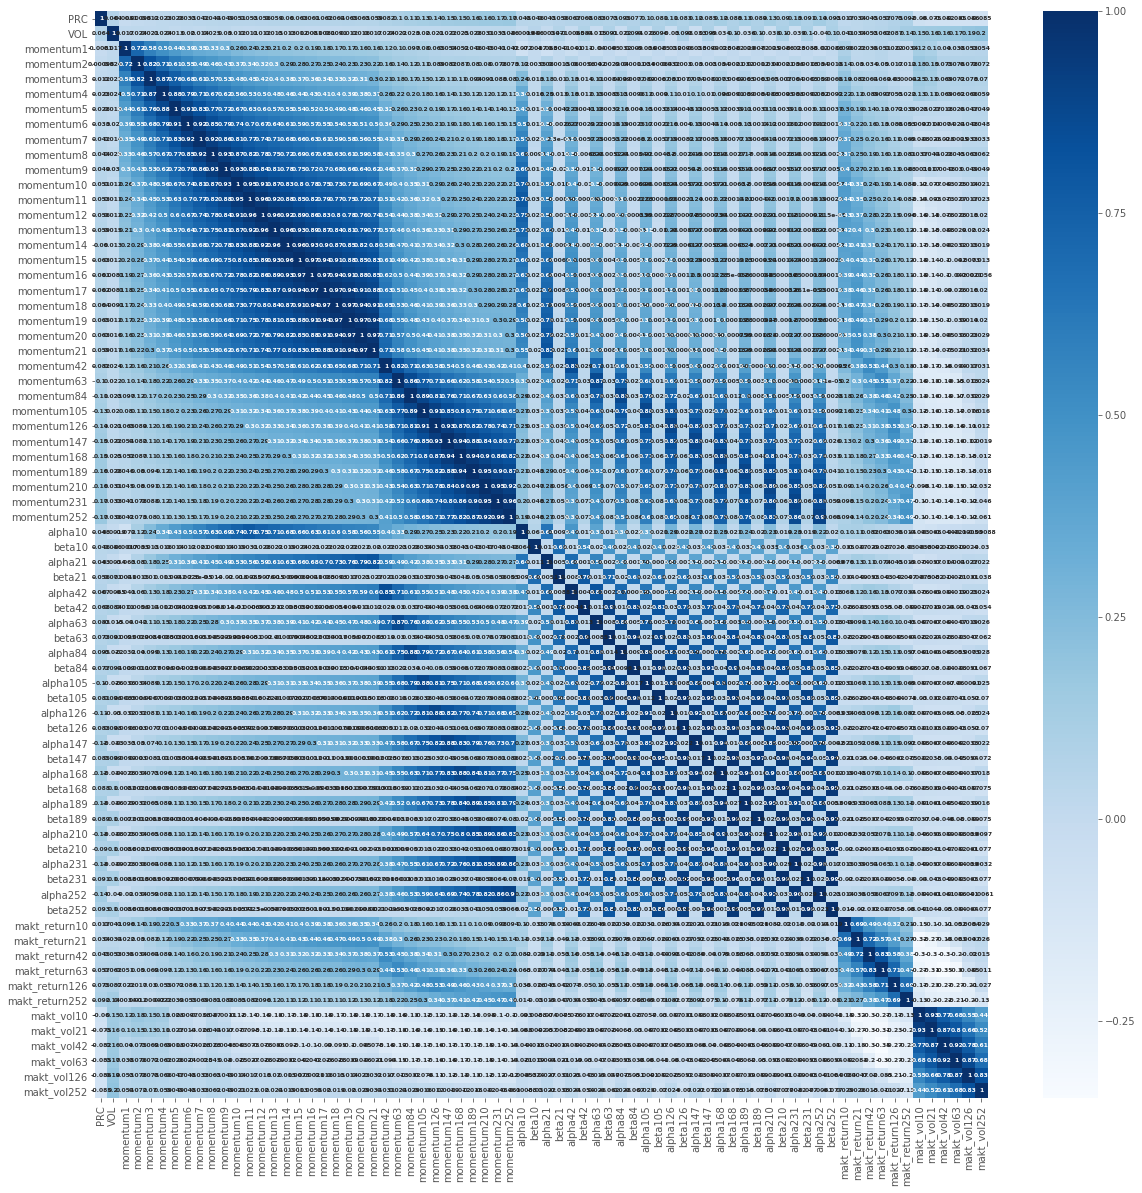

In [17]:
fig = plt.figure(figsize= (20,20))
ax = fig.add_subplot(111)
ax = sns.heatmap(X_train[feature_all].corr(),\
                 annot=True,annot_kws={'size':6,'weight':'bold'},cmap="Blues")

# Basic Models

### Lasso

In [36]:
lasso1 = LogisticRegression(penalty='l1')
lasso1.fit(X_train, y_train)

/Users/zhou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
train_pred = lasso1.predict(X_train)
(train_pred != y_train).mean()

0.492242799997096

### RF

In [41]:
rf1 = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=0)
rf1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [44]:
val_pred = rf1.predict(X_val)
(val_pred != y_val).mean()

0.5058794387212403

In [46]:
prob1 = rf1.predict_proba(X_val)[:, 1]
prob1

array([0.50061704, 0.49781259, 0.48923506, ..., 0.49586326, 0.50199778,
       0.49910938])

In [48]:
top1000 = np.argsort(prob1)[::-1][:1000]
np.mean(np.array(y_val)[top1000])

0.497

In [55]:
param_range = np.arange(1, 250, 2)

train_scores, test_scores = validation_curve(RandomForestClassifier(), 
                                             X_train, 
                                             y_train, 
                                             param_name="n_estimators", 
                                             param_range=param_range,
                                             cv=3, 
                                             scoring="accuracy", 
                                             n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

/Users/zhou/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


KeyboardInterrupt: 

In [ ]:
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

In [52]:
paragrid = 
{'n_estimators': [400]
}

GridSearchCV(RandomForestClassifier, paragrid)

sklearn.model_selection._search.GridSearchCV

In [60]:
%%R -i X_train -i y_train
library(randomForest)
r_train = cbind(X_train, y_train)
head(r_train)

     PRC  VOL     momentum1 momentum2 momentum3 momentum4 momentum5 momentum6
0 84.000 2798 -8.673617e-18  0.015106  0.012094  0.015115  0.027347  0.033501
1 55.625 1629 -6.696000e-03 -0.011140 -0.004429 -0.006661 -0.032748 -0.049842
2 48.750 4538 -3.469447e-18 -0.007634  0.000058  0.000058 -0.002500 -0.002500
3  8.000 1706  1.587300e-02  0.000248  0.000248  0.000248  0.084994  0.102235
4 15.500 1133  3.333300e-02  0.050282  0.041879  0.041879  0.076662  0.076662
5 63.625 4387 -4.510281e-17 -0.028626 -0.054648 -0.039554  0.005811  0.040505
  momentum7 momentum8 momentum9 momentum10 momentum11 momentum12 momentum13
0  0.053909  0.052342  0.043025   0.047705   0.039965   0.046196   0.050891
1 -0.049842 -0.043390 -0.039070  -0.045508  -0.047649  -0.049786  -0.030178
2 -0.002500 -0.015126 -0.017645  -0.030083  -0.014931  -0.029856  -0.054128
3  0.102235  0.137949  0.137949   0.174986   0.074986   0.058593   0.042464
4  0.076662  0.085434  0.085434   0.076738   0.112774   0.095075   0.10400

In [ ]:
%%R
randomForest(y_train~., data=r_train, n_trees=100)

# Compute post prob

In [51]:
'''
compute post prob for each stock at each day.
'''

#date_test = X_test["date"].unique()
#ticker_test = X_test["TICKER"].unique()

post_prob = pd.DataFrame(columns=ticker_test)
for i in date_test:
    #model.predict_proba(X_test[feature_all])
    post_prob.loc[i] = 0
#post_prob

# Back test

In [20]:
# use post_prob as input 